# Chapter 10: Deep learning in Finance

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Deep learning for tabular data 

In [3]:
from fastai import *
from fastai.tabular import *
import torch
import pandas as pd

In [4]:
from chapter_10_utils import performance_evaluation_report

In [5]:
#Load the dataset from CSV file
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')

In [6]:
df.payment_status_sep.unique()

array(['Payment delayed 2 months', 'Payed duly', 'Unknown', 'Payment delayed 1 month', 'Payment delayed 3 months',
       'Payment delayed 4 months', 'Payment delayed 8 months', 'Payment delayed 7 months', 'Payment delayed 5 months',
       'Payment delayed 6 months'], dtype=object)

In [7]:
#Identify the dependent variabe and numerical/categorical features
der_var = 'default_payment_next_month'

num_features = list(df.select_dtypes('number').columns)
num_features.remove(der_var)
cat_features = list(df.select_dtypes('object').columns)

preprocessing = [FillMissing, Categorify, Normalize]

In [ ]:
#Create TabularDataBunch from the DataFrame
data = (TabularList.from_df(df,
                           cat_names=cat_features, 
                           cont_names = num_features,
                           procs = preprocessing)
                   .split_by_rand_pct(valid_pct=0.2)
                   .label_from_df(cols=der_var)
                   .databunch(num_workers=0))

In [9]:
#Create data using sk.learn StratifiedKFolf, better for class imbalance
from sklearn.model_selection import StratifiedKFold

X = df.copy()
y = X.pop(der_var)

train_ind, test_ind = next(StratifiedKFold(n_splits=5).split(X,y))

data = (TabularList.from_df(df,
                           cat_names=cat_features, 
                           cont_names = num_features,
                           procs = preprocessing)
                   .split_by_idxs(train_idx=list(train_ind),
                                  valid_idx=list(test_ind))
                   .label_from_df(cols=der_var)
                   .databunch(num_workers=0))

In [10]:
#Inspect rows:
data.show_batch(rows=5)

sex,education,marriage,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,payment_status_apr,age_na,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,target
Male,High school,Single,Unknown,Unknown,Unknown,Payment delayed 2 months,Unknown,Unknown,False,-0.9101,0.9256,-0.0210,0.0162,0.0609,0.0942,-0.3449,-0.3379,-0.2316,-0.0523,-0.3041,-0.2539,-0.2697,-0.2412,0
Female,Graduate school,Single,Payed duly,Payed duly,Payed duly,Unknown,Payed duly,Payed duly,False,0.6319,-0.7095,-0.4562,-0.5570,-0.5855,-0.6364,-0.6263,-0.6127,0.2484,0.0469,-0.1627,-0.1495,-0.1286,0.3182,0
Female,University,Married,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,False,-0.6788,1.3616,0.3822,0.4001,-0.2170,-0.2819,-0.1719,-0.1635,-0.2018,-0.2080,-0.2478,0.0712,-0.1836,-0.2429,0
Female,University,Married,Payment delayed 1 month,Payment delayed 2 months,Unknown,Unknown,Unknown,Unknown,False,-0.9101,-1.1455,-0.4357,-0.4302,-0.4019,-0.3873,-0.5919,-0.6241,-0.3359,-0.2182,-0.2773,-0.2989,-0.3147,-0.2982,0
Male,University,Married,Payment delayed 4 months,Payment delayed 3 months,Payment delayed 2 months,Unknown,Unknown,Unknown,False,-0.9101,-0.6005,-0.0208,-0.0076,-0.0045,0.0609,0.1362,0.1868,-0.3359,-0.2734,-0.1917,-0.1807,-0.1836,0.0440,1


In [11]:
#Define learner object
learn = tabular_learner(data, layers=[1000,500],
                        ps=[0.001, 0.01],
                        emb_drop=0.04,
                        metrics=[Recall(),
                                 FBeta(beta=1),
                                 FBeta(beta=5)])

In [12]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(5, 4)
    (2): Embedding(4, 3)
    (3): Embedding(11, 6)
    (4): Embedding(11, 6)
    (5): Embedding(11, 6)
    (6): Embedding(11, 6)
    (7): Embedding(10, 6)
    (8): Embedding(10, 6)
    (9): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=63, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=2, bias=True)
  )
)

epoch,train_loss,valid_loss,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 2.75E-03


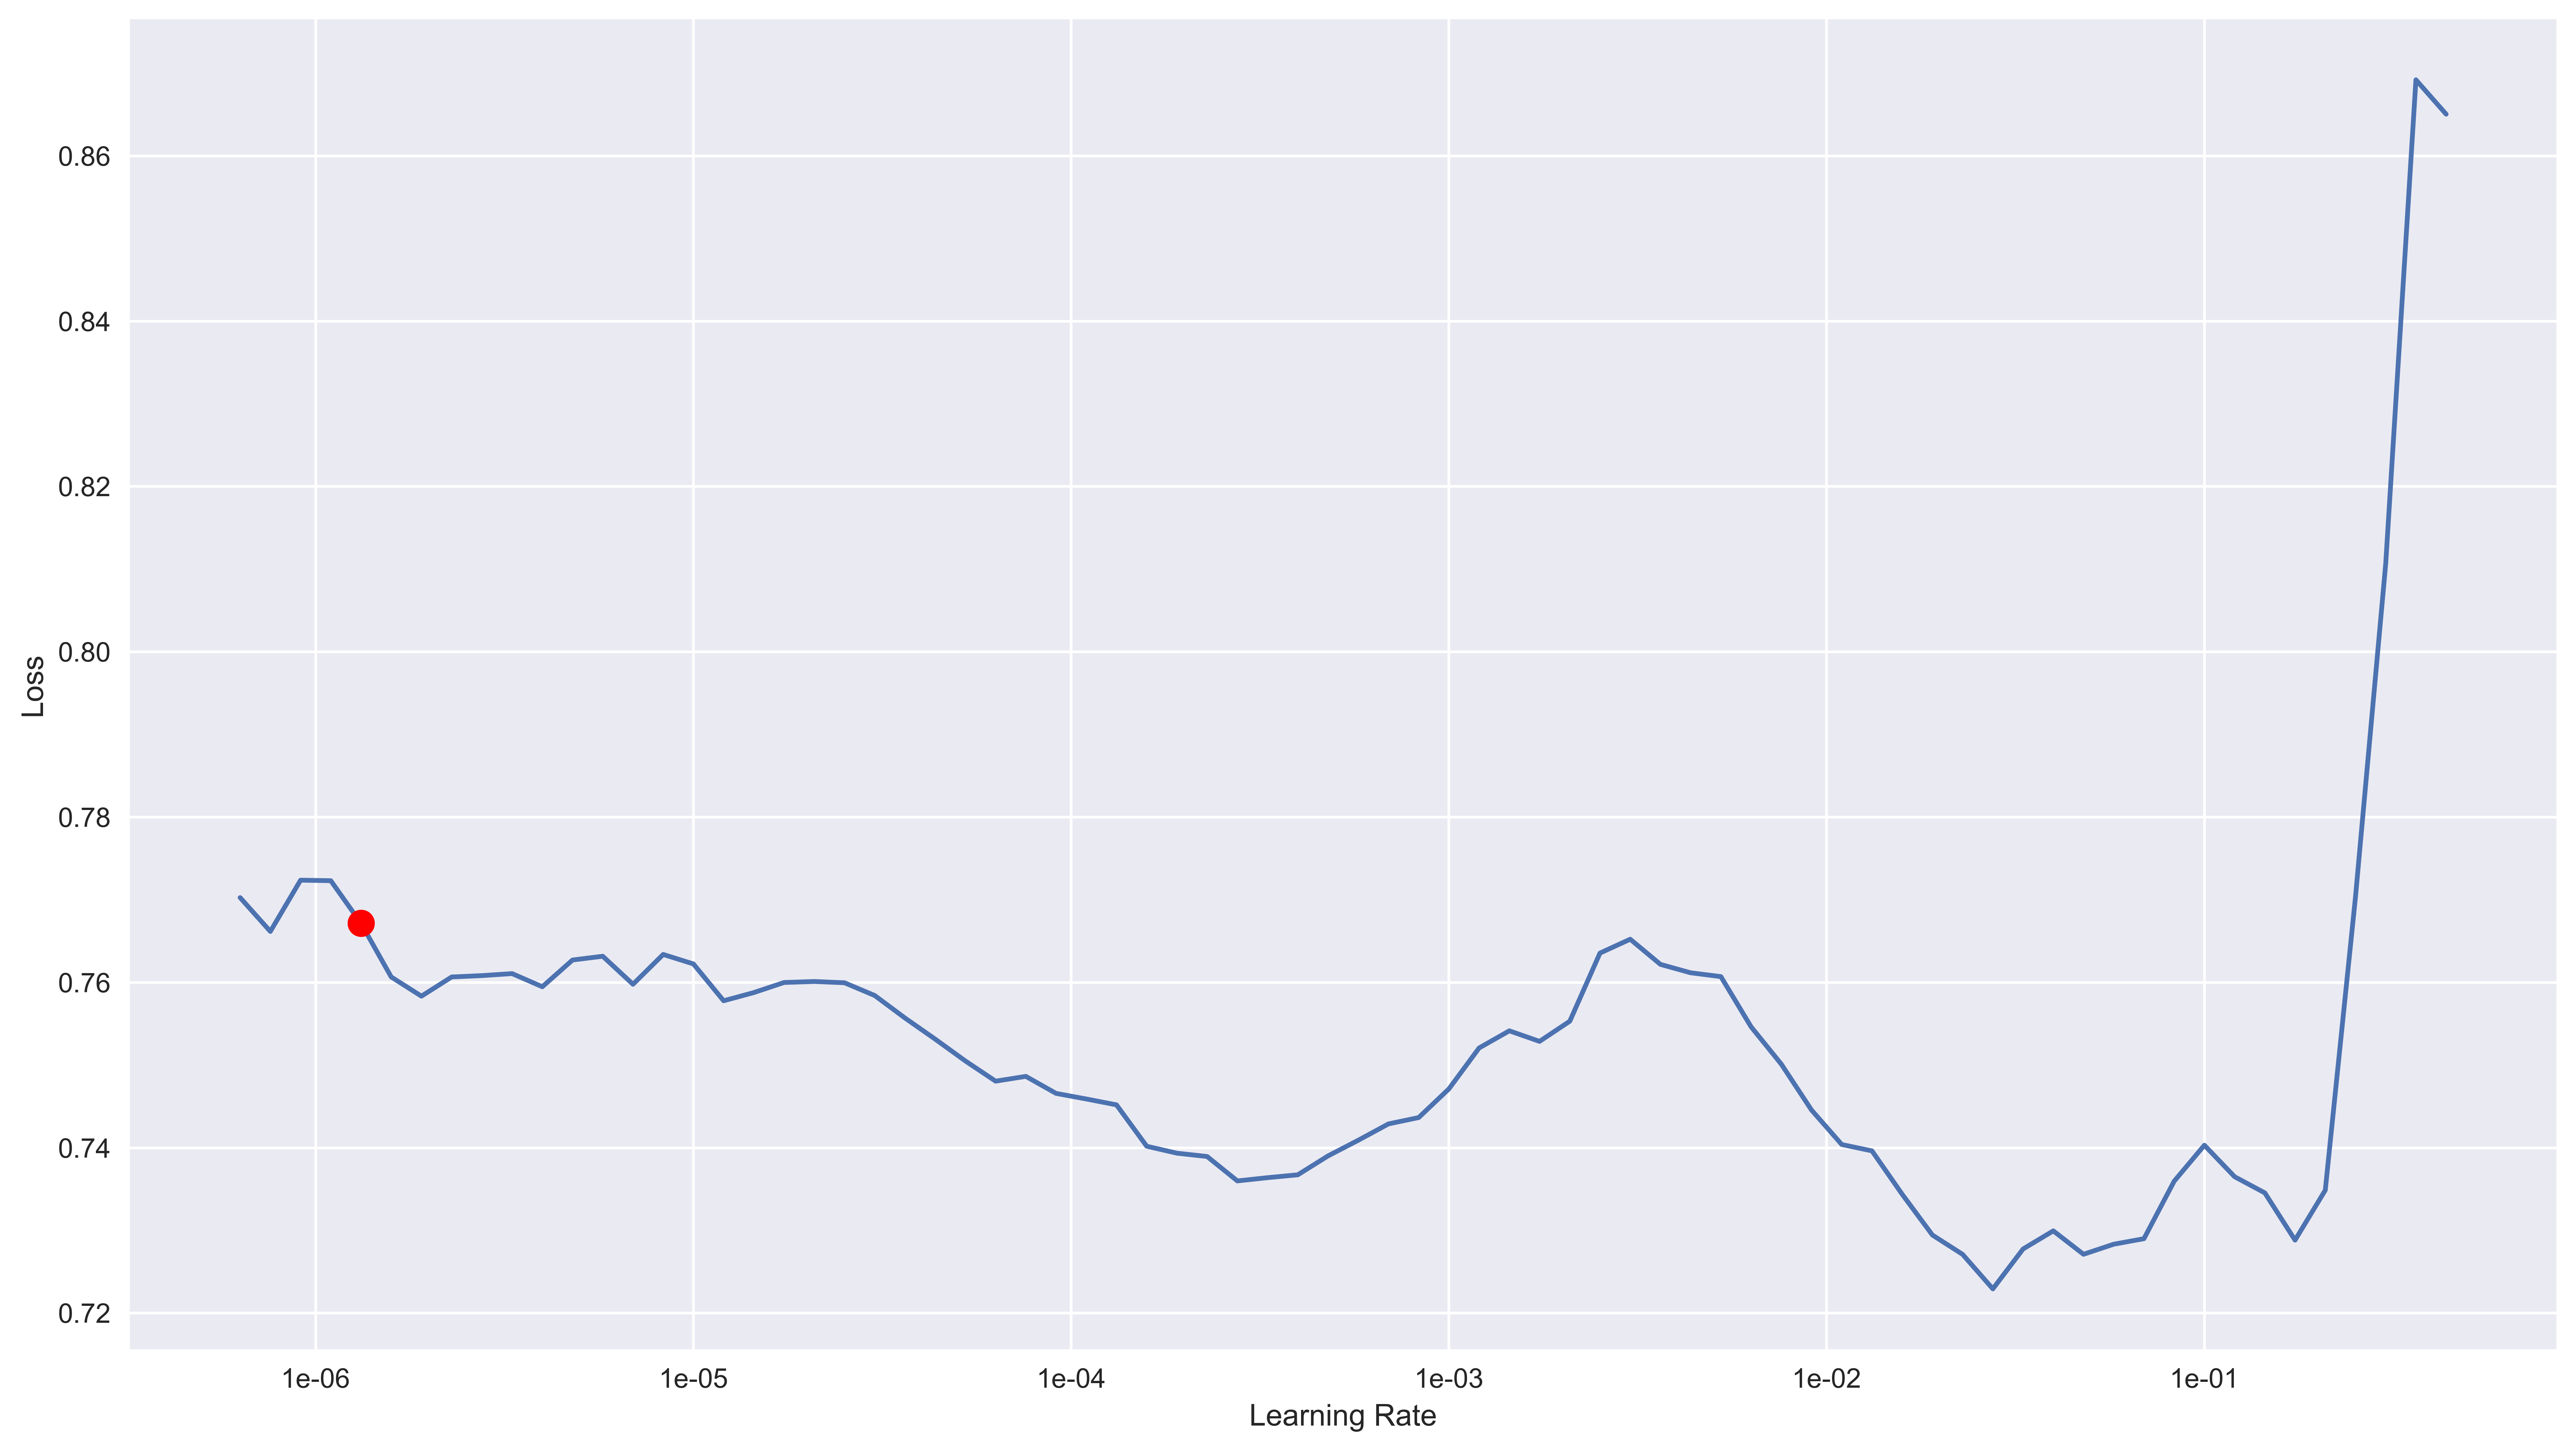

In [13]:
#Find suggested learning rate:
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [14]:
#Train neural network
learn.fit(epochs=25, lr=1.32E-06, wd=0.2)

epoch,train_loss,valid_loss,recall,f_beta,f_beta,time
0,0.695059,0.678699,0.597139,0.374057,0.570946,00:17
1,0.678441,0.650613,0.488705,0.361258,0.475793,00:17
2,0.676023,0.648932,0.489458,0.374748,0.478198,00:18
3,0.659420,0.633508,0.472892,0.382577,0.464457,00:17
4,0.659104,0.638228,0.512048,0.396964,0.500878,00:17
5,0.653638,0.629077,0.483434,0.390749,0.474771,00:17
6,0.649339,0.616822,0.409639,0.373755,0.406635,00:17
7,0.645158,0.618210,0.428464,0.388396,0.425090,00:18
8,0.645921,0.609645,0.383283,0.372212,0.382408,00:20
9,0.640958,0.607890,0.414157,0.389381,0.412139,00:17


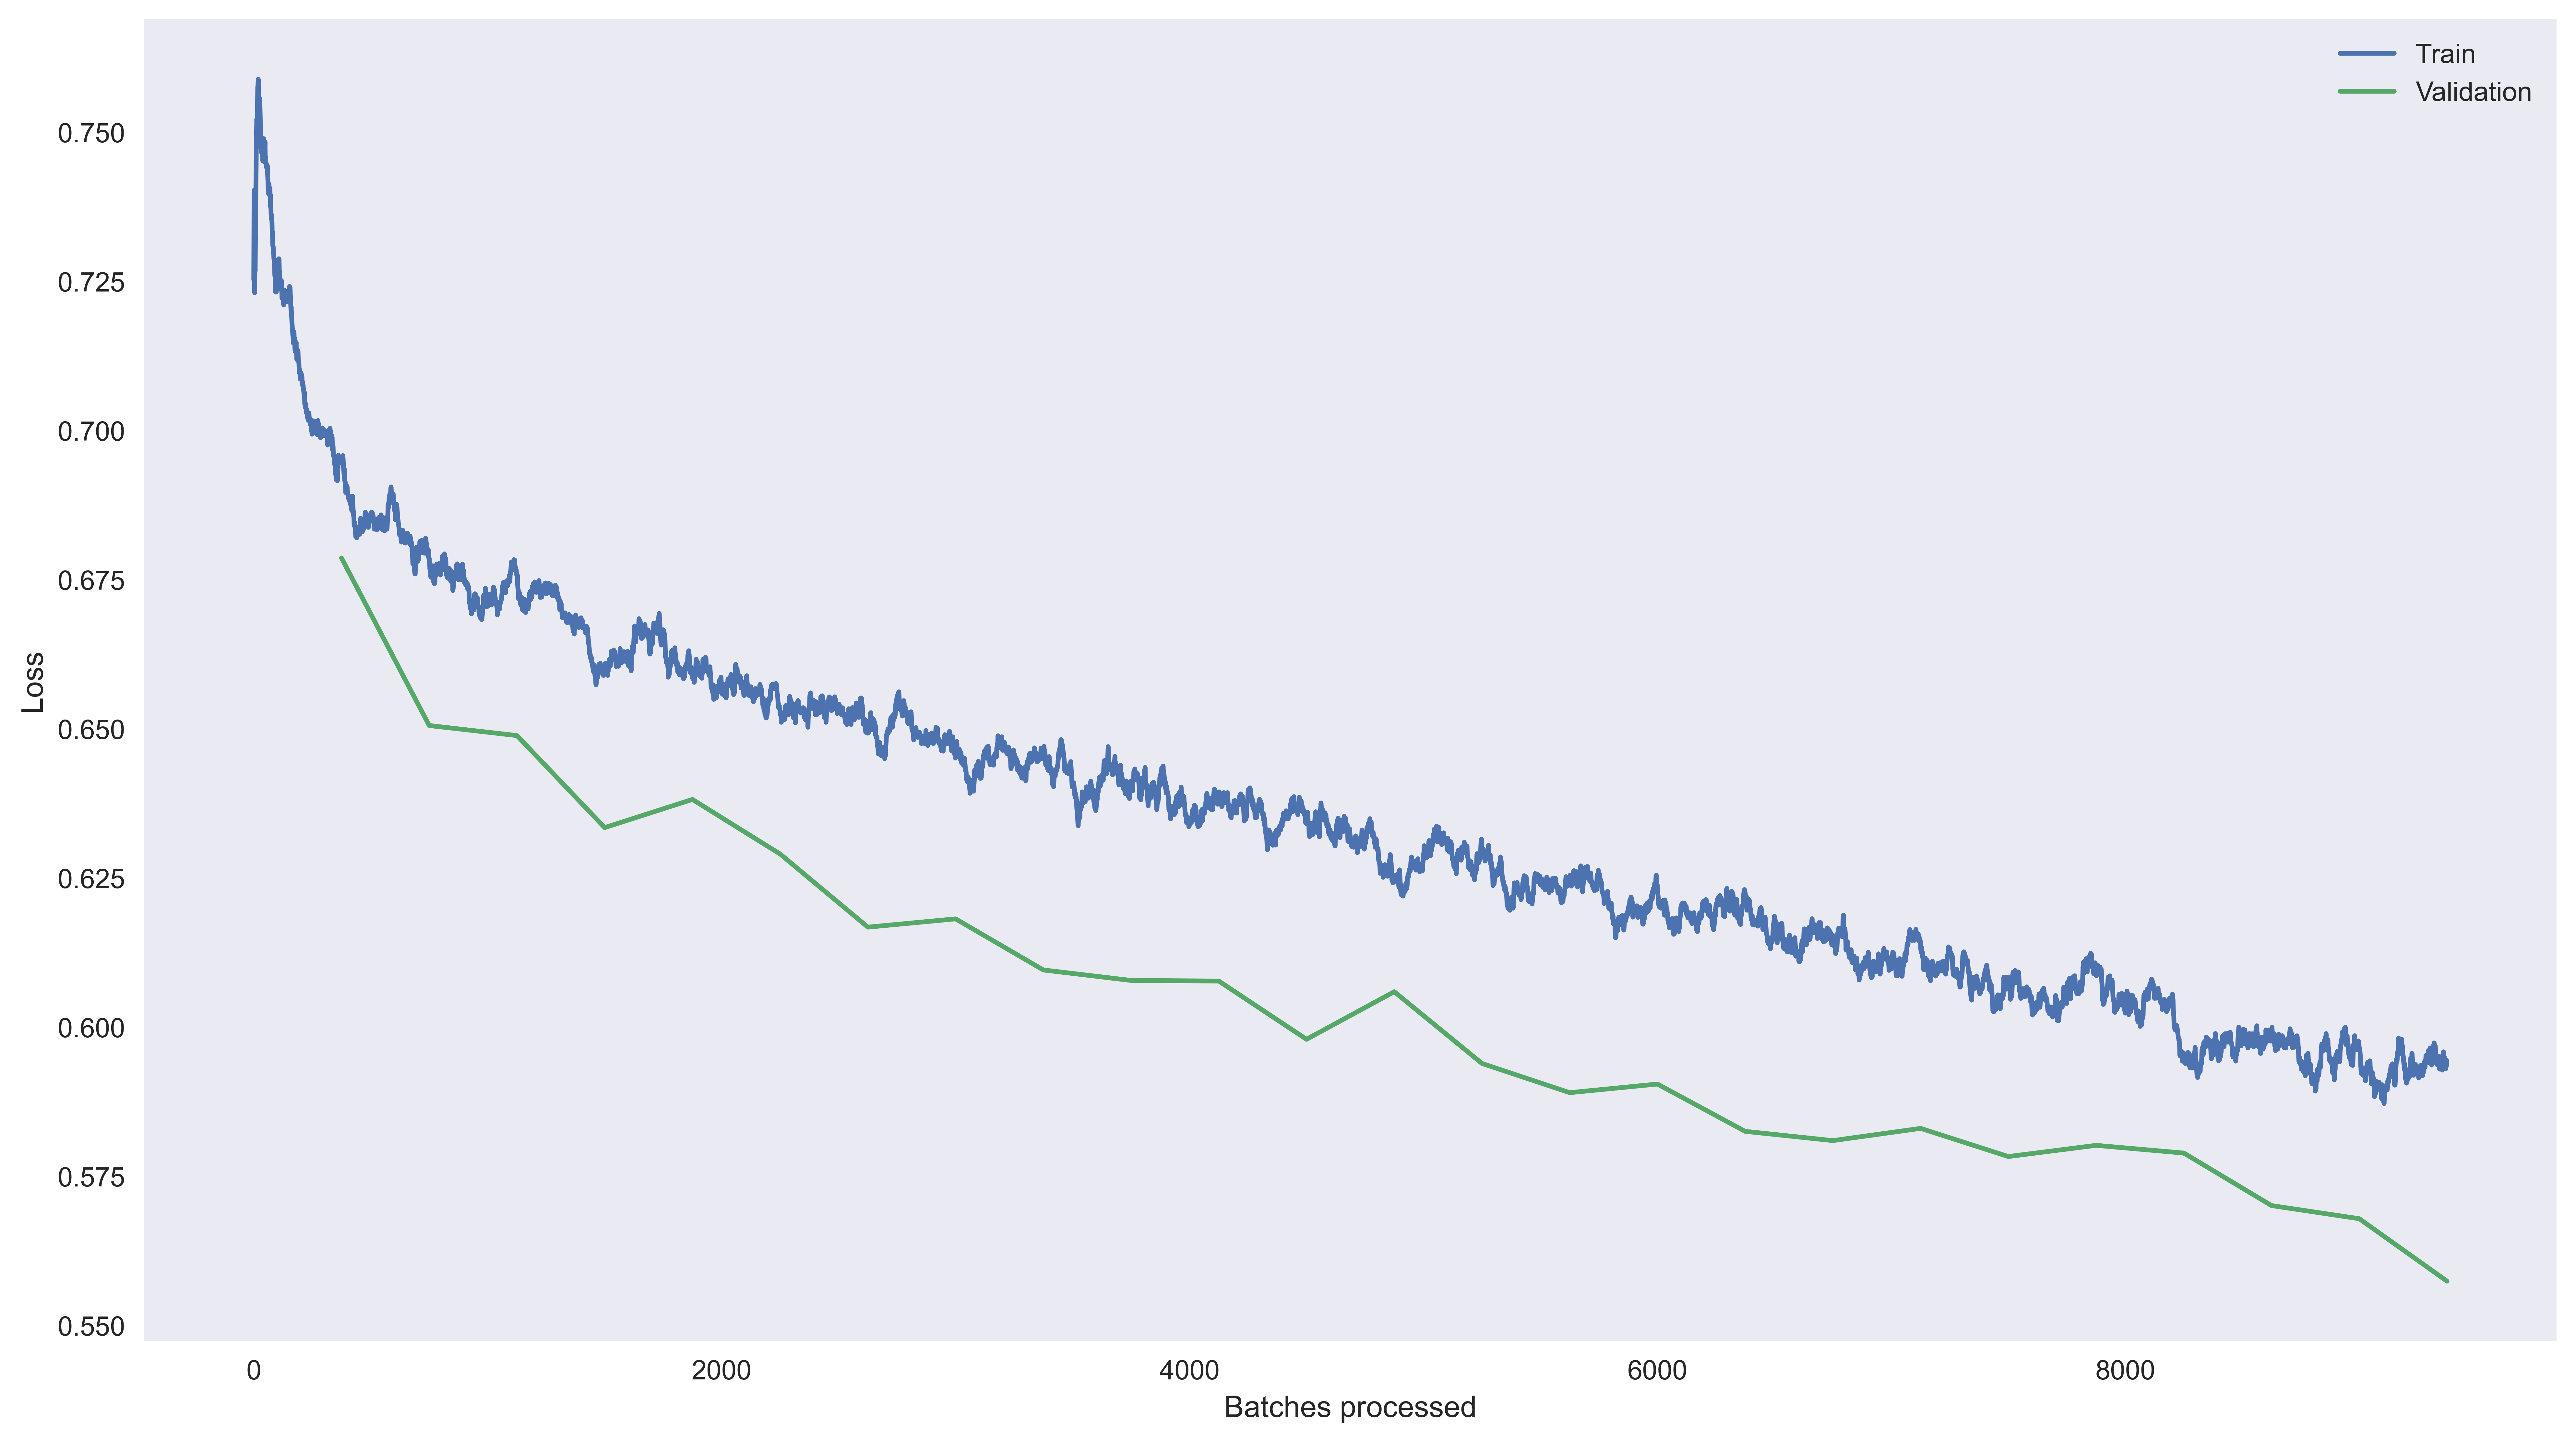

In [15]:
learn.recorder.plot_losses()

In [16]:
#Extract predictions for the validation set
preds_valid, _ = learn.get_preds(ds_type=DatasetType.Valid)
pred_valid = preds_valid.argmax(dim=-1)


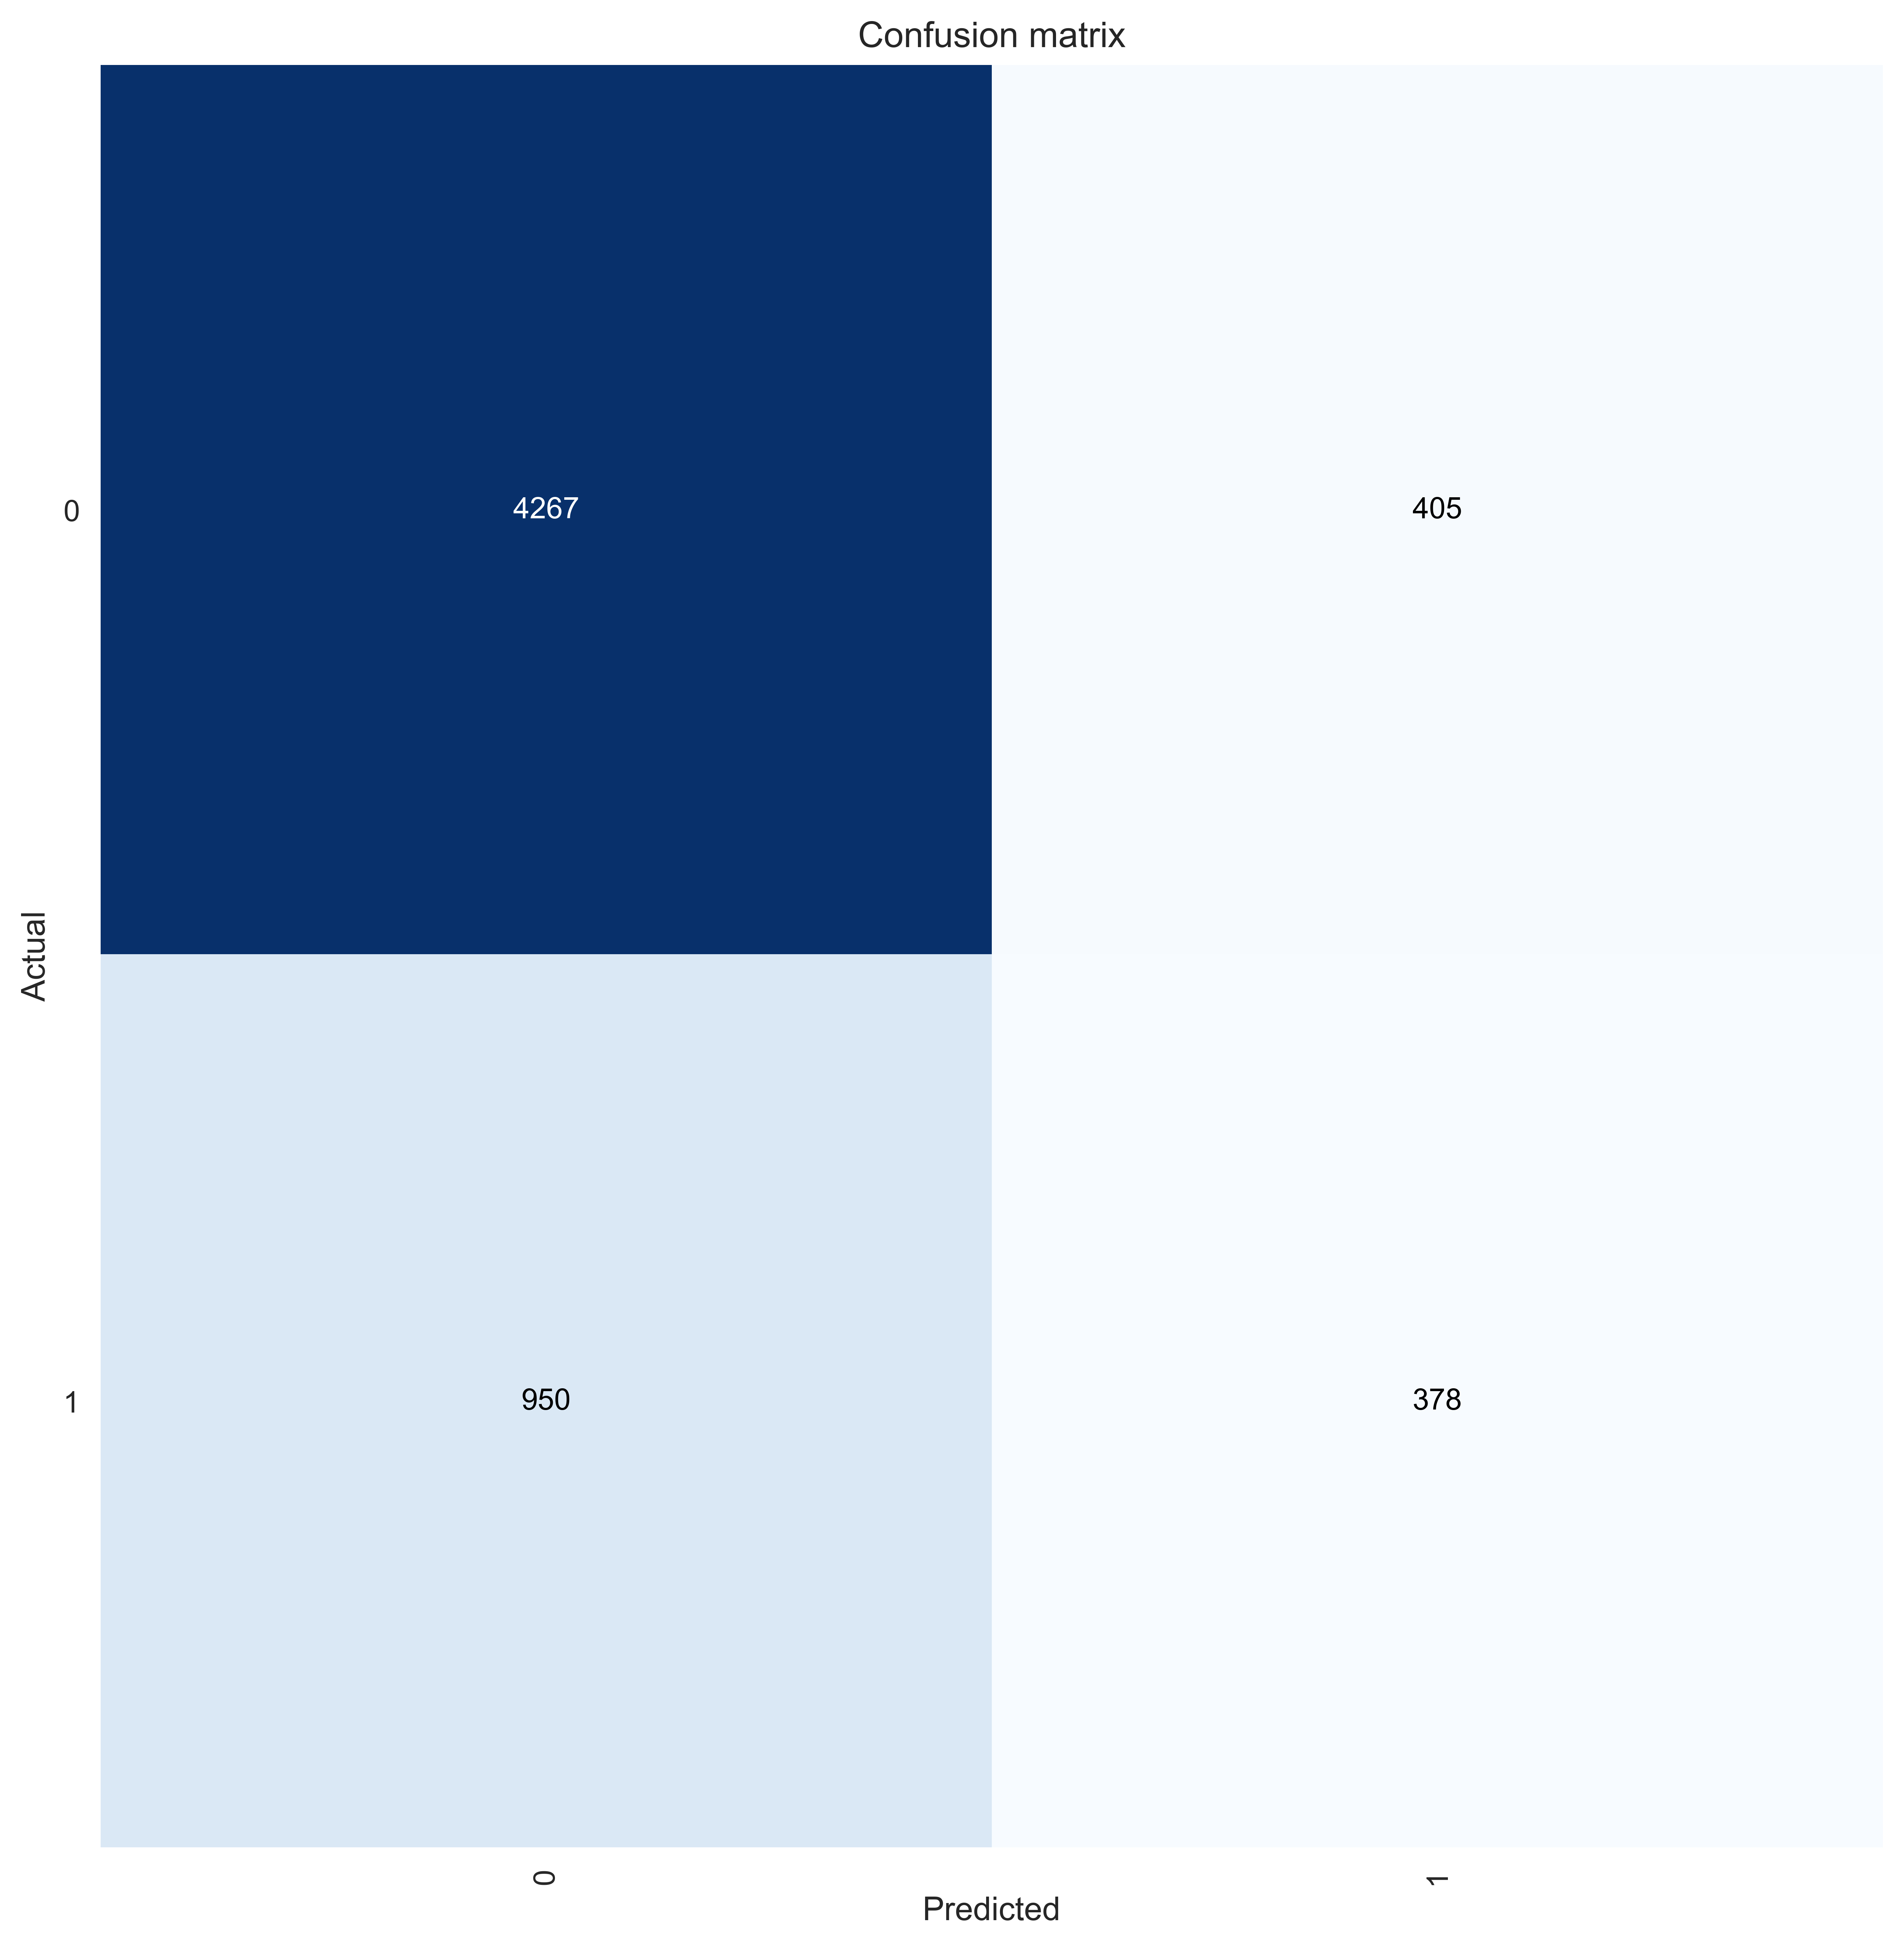

In [17]:
#Inspect the performance 
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [18]:
#Inspect performance evaluation metrics 
performance_evaluation_report(learn)

{'accuracy': 0.7741666666666667,
 'precision': 0.4827586206896552,
 'recall': 0.28463855421686746,
 'specificity': 0.9133133561643836,
 'f1_score': 0.35812411179535764,
 'cohens_kappa': 0.23203007041519108,
 'roc_auc': 0.6948275228482423,
 'pr_auc': 0.38967602354442177}